#**Importing libraries**

In [73]:
!pip install opencv-python matplotlib tensorflow

In [74]:
!pip list

Package                      Version
---------------------------- ------------
absl-py                      2.0.0
asttokens                    2.4.1
astunparse                   1.6.3
cachetools                   5.3.2
certifi                      2023.11.17
charset-normalizer           3.3.2
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.2.0
cycler                       0.12.1
debugpy                      1.8.0
decorator                    5.1.1
executing                    2.0.1
flatbuffers                  23.5.26
fonttools                    4.47.0
gast                         0.5.4
google-auth                  2.26.1
google-auth-oauthlib         1.2.0
google-pasta                 0.2.0
grpcio                       1.60.0
h5py                         3.10.0
idna                         3.6
ipykernel                    6.28.0
ipython                      8.19.0
jedi                         0.19.1
joblib                       1.3.

In [106]:
import tensorflow as tf
import os
#from google.colab import drive
import numpy as np
from matplotlib import pyplot as plt

In [107]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [108]:
tf.config.list_physical_devices('GPU')

[]

#**Split data**

Initial dataset consist of 2 classes *('FAKE', 'REAL')*, each class consist of **60 000** images.

The data was split into three folders using below mentioned script.

**85%** - **TRAIN** data, **10%** - **VALIDATION** data, **5%** - **TEST** data

In [ ]:
!pip install split-folders

In [ ]:
#import splitfolders

# splitfolders.ratio("data", # The location of dataset
#                    output="ai_real_dataset", # The output location
#                    seed=42, # The number of seed
#                    ratio=(.85, .10, .05), # The ratio of splited dataset
#                    group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
#                    move=False # If you choose to move, turn this into True
#                    )

#splitfolders.ratio("C:/Users/jan.kowalski/Desktop/ISA_II/GSN/data",
#                   output="C:/Users/jan.kowalski/Desktop/ISA_II/GSN/output",
#                   seed=42,
#                   ratio=(.85, .1, .05),
#                   group_prefix=None,
#                   move=False)

#**Load dataset**

## Load dataset from drive

In [ ]:
#drive.mount('/content/drive')

In [ ]:
#!unzip -uq "/content/drive/My Drive/ai_real_dataset.zip" -d "/content"

## Initiate Keras datasets from the uploaded files

In [109]:
base='C:/Users/jan.kowalski/Desktop/ISA_II/GSN/output'
train_dir = os.path.join(base, 'train')
validation_dir = os.path.join(base, 'val')
test_dir = os.path.join(base, 'test')

#train_dir = os.path.join('ai_real_dataset', 'train')
#validation_dir = os.path.join('ai_real_dataset', 'val')
#test_dir = os.path.join('ai_real_dataset', 'test')

In [110]:
BATCH_SIZE = 128
IMG_SIZE = (32, 32)
IMG_SHAPE = IMG_SIZE + (3,)

In [111]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 102000 files belonging to 2 classes.


In [112]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 12000 files belonging to 2 classes.


In [113]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6000 files belonging to 2 classes.


## Plot images

['FAKE', 'REAL']


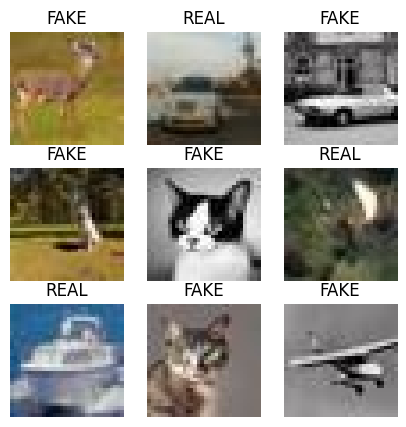

In [114]:
class_names = train_dataset.class_names

print(class_names)

plt.figure(figsize=(5, 5))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [115]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 797
Number of validation batches: 94
Number of test batches: 47


#### Optimize data loading performance

In [116]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# **Data augmentation**

## Augmentation layers

* **tf.keras.layers.RandomContrast(0.7):** randomly adjusts the contrast of images by a factor of 0.7, introducing variation in image appearance.

* **tf.keras.layers.RandomFlip('horizontal')**: randomly flips images horizontally, creating mirrored versions of the original images.

* **tf.keras.layers.RandomRotation(0.2)**: randomly rotates images by up to 0.2 radians, adding rotation-based diversity to the dataset.

* **tf.keras.layers.RandomZoom(0.3, 0.2)**: randomly zooms in or out on images, with zoom factors ranging from 0.3 to 0.2.

In [117]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomContrast(0.7),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.3, 0.2),
])

## Augmentation visualization

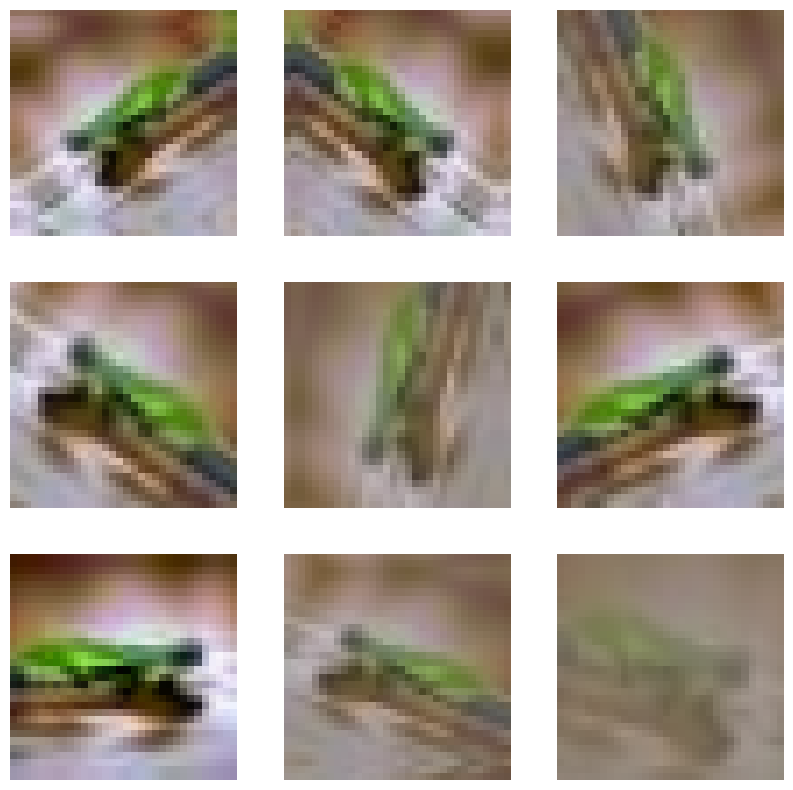

In [118]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## **CNN**

### Import libraries

In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from keras.activations import relu
from tensorflow.keras import layers
from tensorflow.keras.applications.efficientnet import preprocess_input

### Build a model

In [126]:
# Define the model
model1 = tf.keras.Sequential()

# Convolutional layers
model1.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=IMG_SHAPE))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model1.add(layers.Flatten())

# Dense layers
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))  # Optional dropout for regularization
model1.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)

### Compile the model

In [127]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Model summary

In [128]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 15, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 6, 6, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 2, 2, 64)         

### Data augmentation on train dataset

In [129]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(32,32),  # all images will be resized to 32x32
        batch_size=BATCH_SIZE,
        class_mode='binary')

  #tf.keras.layers.RandomContrast(0.7),

Found 102000 images belonging to 2 classes.


### Creating a checkpoint callback for saving weights

In [130]:
checkpoint_path ="cnn/cnn-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True,verbose=1)

### Loading weights from the latest checkpoint

In [131]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model1.load_weights(latest)

### Training model

In [132]:
#history1 = model1.fit(train_dataset,
history1 = model1.fit(train_generator,
                    epochs=1,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback])

797/797 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.8813
Epoch 1: saving model to cnn\cnn-0001.ckpt
797/797 [==============================] - 147s 183ms/step - loss: 0.2902 - accuracy: 0.8813 - val_loss: 0.3038 - val_accuracy: 0.8737


## **EficientNet**

In [133]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape = IMG_SHAPE)

In [134]:
#base_model.trainable = False

for layer in base_model.layers[:230]:
		layer.trainable = False

# for layer in base_model.layers[18:]:
# 		layer.trainable = True

In [135]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling_6 (Rescaling)     (None, 32, 32, 3)            0         ['input_7[0][0]']             
                                                                                                  
 normalization_3 (Normaliza  (None, 32, 32, 3)            7         ['rescaling_6[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 32, 32, 3)            0         ['normalization_3

In [136]:
inputs = layers.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)

x = preprocess_input(x)
x = base_model(x)
#x = AveragePooling2D(8,8)(x)
x = layers.Flatten(name="flatten")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)

In [137]:
model2 = Model(inputs, outputs)

In [138]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model2.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy() , metrics=['accuracy'])

In [139]:
model2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 sequential_6 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, 1, 1, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dropout_11 (Dropout)        (None, 1280)              0         
                                                                 
 dense_16 (Dense)            (None, 128)               163968    
                                                           

### Creating a checkpoint callback for saving weights

In [140]:
checkpoint_path2 ="eff/eff-{epoch:04d}.ckpt"
checkpoint_dir2 = os.path.dirname(checkpoint_path2)
cp_callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path2,save_weights_only=True,verbose=1)

### Loading weights from the latest checkpoint

In [141]:
latest2 = tf.train.latest_checkpoint(checkpoint_dir2)
model2.load_weights(latest2)

In [142]:
history2 = model2.fit(train_dataset,
                    epochs=1,
                    validation_data=validation_dataset,
                    callbacks=[cp_callback2])

797/797 [==============================] - ETA: 0s - loss: 0.5630 - accuracy: 0.7258
Epoch 1: saving model to eff\eff-0001.ckpt
797/797 [==============================] - 81s 95ms/step - loss: 0.5630 - accuracy: 0.7258 - val_loss: 0.4262 - val_accuracy: 0.8069


## **Training process analysis**

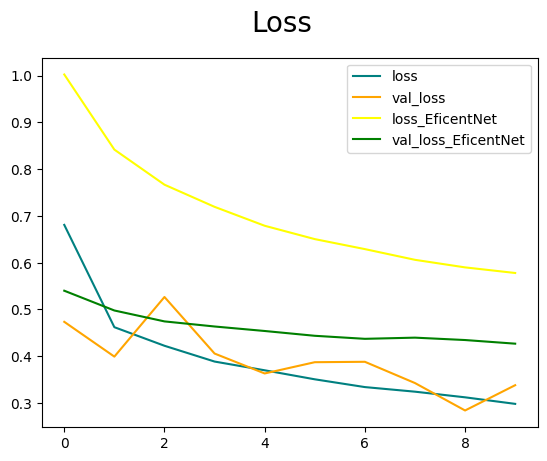

In [104]:
from matplotlib import pyplot as plt
fig = plt.figure()
plt.plot(history1.history['loss'], color='teal', label='loss')
plt.plot(history1.history['val_loss'], color='orange', label='val_loss')
plt.plot(history2.history['loss'], color='yellow', label='loss_EficentNet')
plt.plot(history2.history['val_loss'], color='green', label='val_loss_EficentNet')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper right")
plt.show()

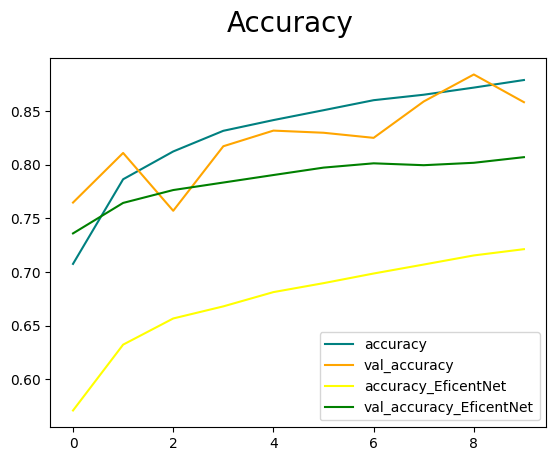

In [105]:
fig = plt.figure()
plt.plot(history1.history['accuracy'], color='teal', label='accuracy')
plt.plot(history1.history['val_accuracy'], color='orange', label='val_accuracy')
plt.plot(history2.history['accuracy'], color='yellow', label='accuracy_EficentNet')
plt.plot(history2.history['val_accuracy'], color='green', label='val_accuracy_EficentNet')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="lower right")
plt.show()

## **Testing**

In [225]:
predicted_classes1 = np.array([])
predicted_classes2 = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predicted_classes1 = np.concatenate([predicted_classes1,
                                       np.array([(0 if z[0]<0.5 else 1) for z in model1.predict(x)])])
  predicted_classes2 = np.concatenate([predicted_classes2,
                       np.argmax(model2.predict(x), axis = -1)])
  labels = np.concatenate([labels, y.numpy()])

4/4 [==============================] - 0s 24ms/step


In [226]:
print(labels)

[0. 1. 1. ... 0. 0. 0.]


[[2894  106]
 [ 654 2346]]
              precision    recall  f1-score   support

        FAKE       0.82      0.96      0.88      3000
        REAL       0.96      0.78      0.86      3000

    accuracy                           0.87      6000
   macro avg       0.89      0.87      0.87      6000
weighted avg       0.89      0.87      0.87      6000



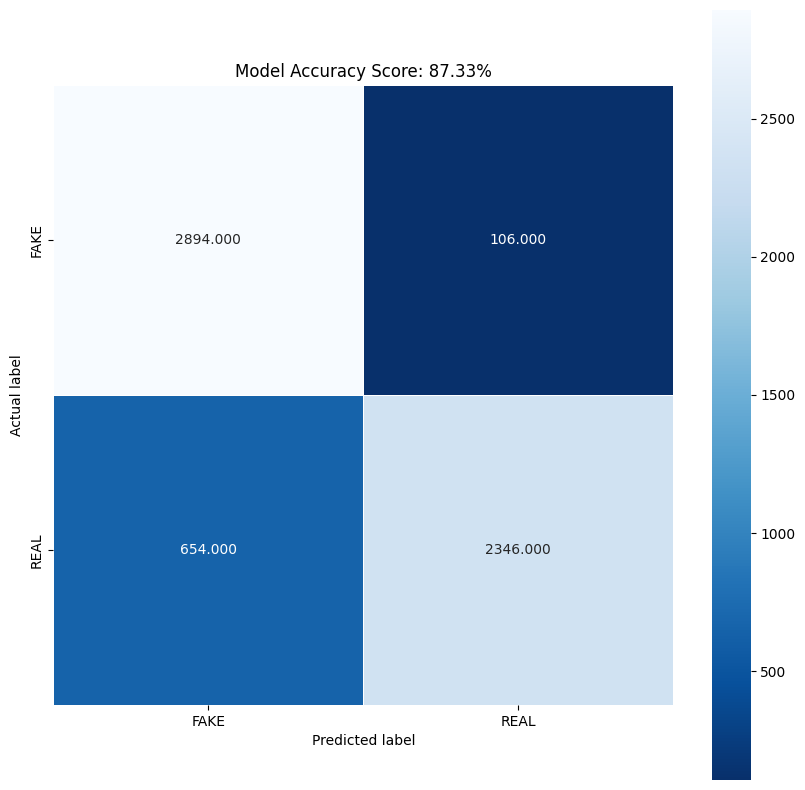

In [227]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

score = model1.evaluate(test_dataset, verbose=0)
cm = confusion_matrix(labels, predicted_classes1)

print(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title)
plt.savefig('foo.png')

print(classification_report(labels, predicted_classes1, target_names=class_names))

[[2714  286]
 [ 910 2090]]
              precision    recall  f1-score   support

        FAKE       0.75      0.90      0.82      3000
        REAL       0.88      0.70      0.78      3000

    accuracy                           0.80      6000
   macro avg       0.81      0.80      0.80      6000
weighted avg       0.81      0.80      0.80      6000



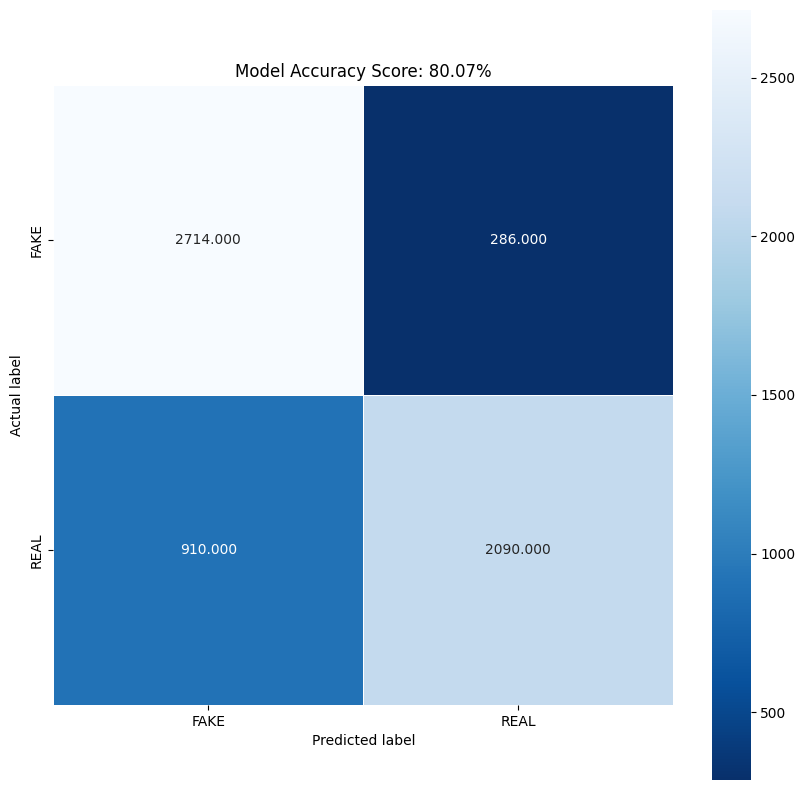

In [228]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

score = model2.evaluate(test_dataset, verbose=0)
cm = confusion_matrix(labels, predicted_classes2)

print(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {score[1]:.2%}'
plt.title(all_sample_title)
plt.savefig('bar.png')

print(classification_report(labels, predicted_classes2, target_names=class_names))

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model

# Ścieżka do folderu z obrazami wejściowymi
input_folder = '/content/drive/My Drive/testing/real'

# Funkcja do przetwarzania obrazów
def process_image(image_path):
    img = image.load_img(image_path, target_size=(32, 32))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalizacja

    return img_array

# Iteruj przez obrazy wejściowe
for filename in os.listdir(input_folder):
        input_image_path = os.path.join(input_folder, filename)

        # Przetwarzaj obraz za pomocą modelu1
        input_img_array = process_image(input_image_path)
        prediction1 = model1.predict(input_img_array)
        class1 = (0 if model1.predict(x)[0]<0.5 else 1)

        # Przetwarzaj obraz za pomocą modelu2
        input_img_array = process_image(input_image_path)
        prediction2 = model2.predict(input_img_array)
        class2 = np.argmax(prediction2)

        # Twórz wykres z podpisem klas
        plt.figure()
        plt.imshow(image.load_img(input_image_path))
        plt.title(f'Class 1: {class1}, Class 2: {class2}')
        plt.show()
